In [3]:
from collections import defaultdict

import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.preprocessing import StandardScaler

from mcda.dataset import MCDADataset

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [5]:
df = MCDADataset.read_csv("./data/eswaR1s.csv").data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [7]:
methods = {
    "PCA": PCA(n_components=2, random_state=42),
    "KernelPCA": KernelPCA(n_components=2, random_state=42),
    "t-SNE": TSNE(n_components=2, perplexity=10, method="exact", random_state=42),
    "MDS": MDS(n_components=2, random_state=42),
    "LLE": LocallyLinearEmbedding(n_components=2, random_state=42),
    "Isomap": Isomap(n_components=2),
    "SpectralEmbedding": SpectralEmbedding(n_components=2, random_state=42),
    "UMAP": UMAP(n_components=2, random_state=42),
}

/usr/local/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


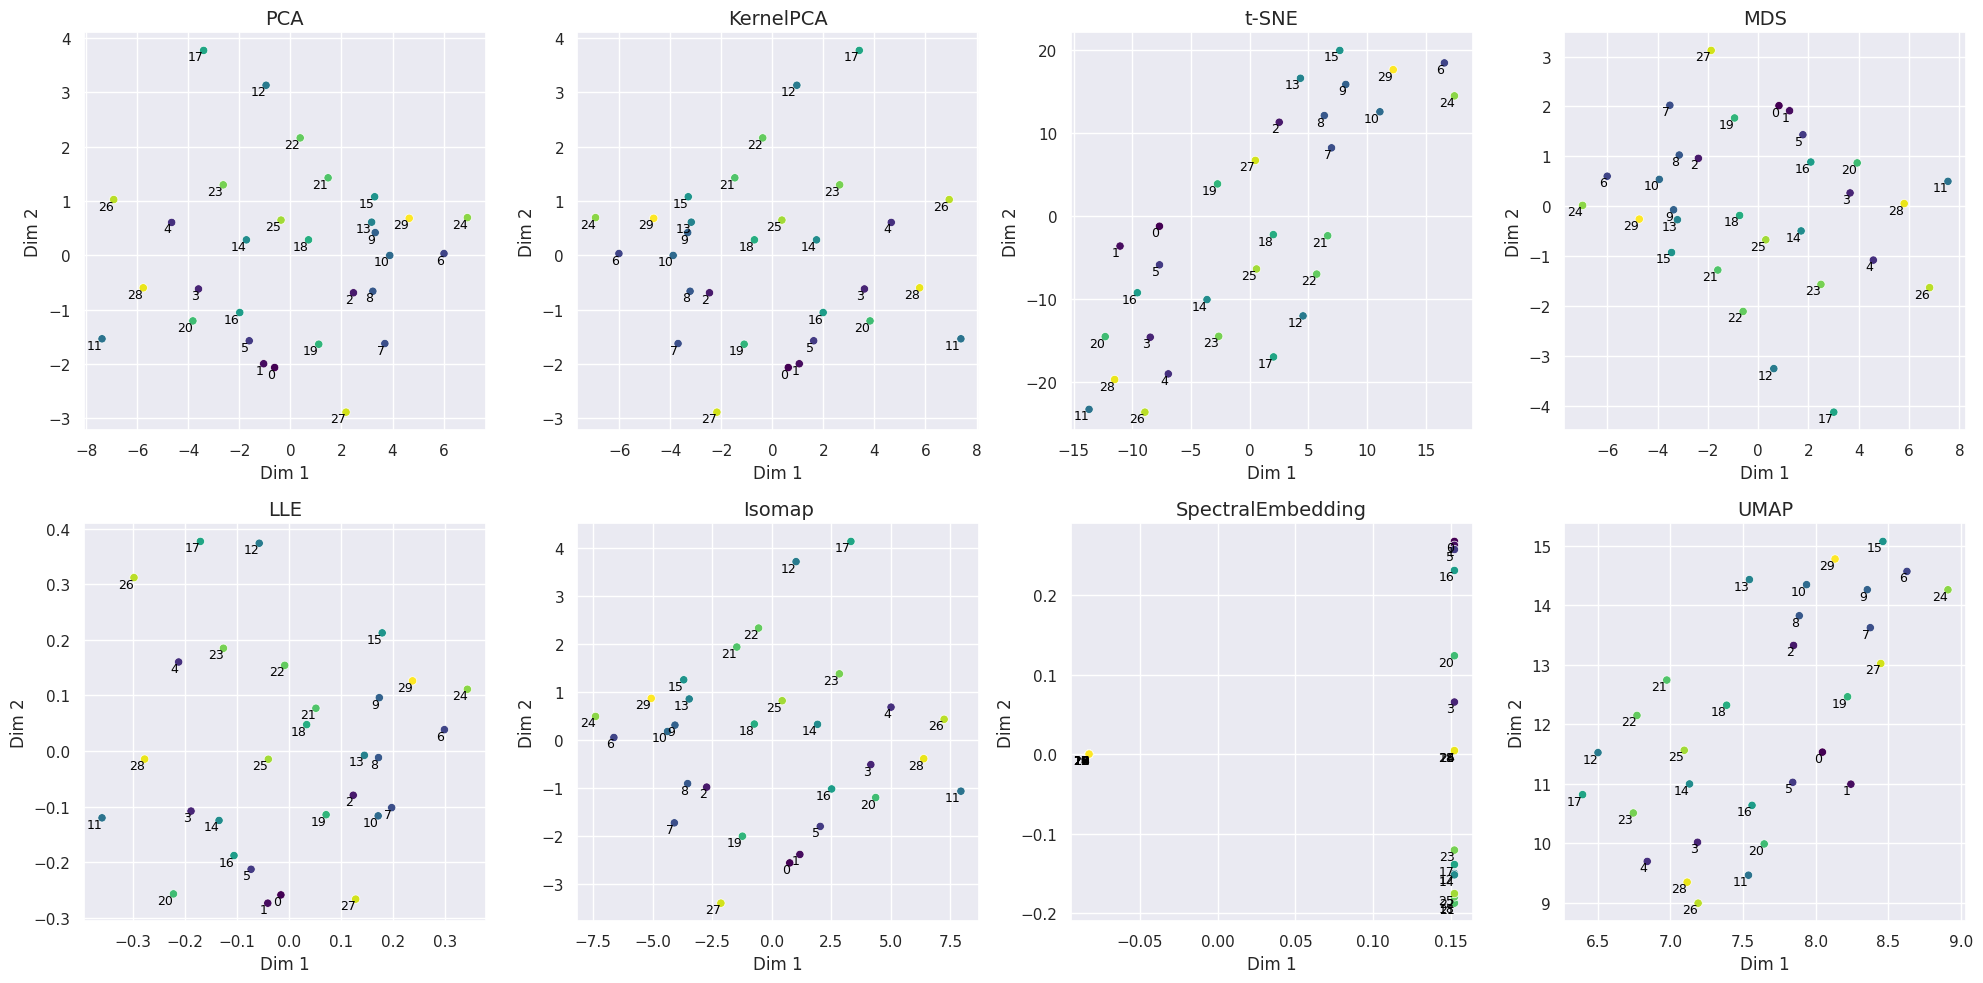

In [10]:
color = np.linspace(0, 1, df_scaled.shape[0])
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df_scaled), index=df.index, columns=["Dim 1", "Dim 2"])

    sns.scatterplot(
        x="Dim 1",
        y="Dim 2",
        hue=color,
        palette="viridis",
        data=df_m,
        ax=axes[i],
        legend=False,
    )
    for j in range(df_m.shape[0]):
        axes[i].text(
            df_m.iloc[j, 0],
            df_m.iloc[j, 1],
            str(df_m.index[j]),
            fontsize=9,
            color="black",
            ha="right",
            va="top",
        )
    axes[i].set_title(f"{method_name}", fontsize=14)
    axes[i].set_xlabel("Dim 1")
    axes[i].set_ylabel("Dim 2")

plt.tight_layout()
plt.savefig("data/plots/2d_plane.png")
plt.show()